In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'MFC Variation 6 CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Manulife Financial Corporation Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.09375,6.133837,-56.250000,1982400.0,2.0
2000-01-24,6.06250,6.122862,-60.000000,1705200.0,2.0
2000-01-25,5.96875,6.099153,-80.000000,909600.0,2.0
2000-01-26,6.00000,6.083898,-73.333333,1179600.0,2.0
2000-01-27,5.96875,6.066183,-80.000000,783000.0,2.0


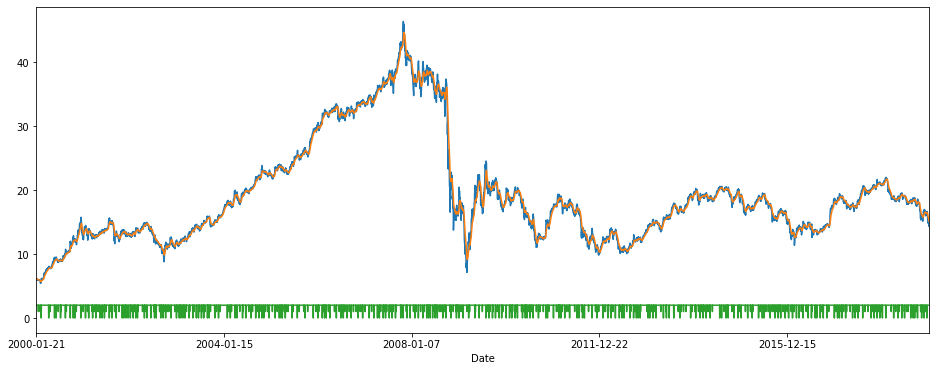

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [8]:
willr_data = np.array(willr_data)
willr_data.shape

(4745, 15, 1)

In [9]:
price_data = np.array(price_data)
price_data.shape

(4745, 15, 1)

In [10]:
ema_data = np.array(ema_data)
ema_data.shape

(4745, 15, 1)

In [11]:
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 4303, 1.0: 214, 0.0: 228})

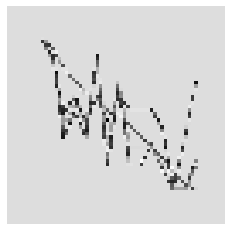

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 6.9523809523809526, 1: 7.3996101364522415, 2: 0.3675089553683803}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.4614 - accuracy: 0.6719 - mse: 5.5666 - weighted_accuracy: 0.3982 - weighted_mse: 6.4582WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 26ms/step - loss: 0.2469 - accuracy: 0.3501 - mse: 1.6065 - weighted_accuracy: 0.3019 - weighted_mse: 1.7280 - val_loss: 0.2252 - val_accuracy: 0.0453 - val_mse: 0.8594 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.8594
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2065 - accuracy: 0.2745 - mse: 1.1804 - weighted_accuracy: 0.3390 - weighted_mse: 1.1879 - val_loss: 0.1970 - val_accuracy: 0.5985 - 

Epoch 27/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1917 - accuracy: 0.2719 - mse: 1.2369 - weighted_accuracy: 0.4431 - weighted_mse: 1.2095 - val_loss: 0.1915 - val_accuracy: 0.2297 - val_mse: 0.9840 - val_weighted_accuracy: 0.2297 - val_weighted_mse: 0.9840
Epoch 28/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1904 - accuracy: 0.2908 - mse: 1.2243 - weighted_accuracy: 0.4474 - weighted_mse: 1.2022 - val_loss: 0.2019 - val_accuracy: 0.0706 - val_mse: 1.0351 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 1.0351
Epoch 29/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1907 - accuracy: 0.2318 - mse: 1.2720 - weighted_accuracy: 0.4584 - weighted_mse: 1.2318 - val_loss: 0.1988 - val_accuracy: 0.0780 - val_mse: 0.9750 - val_weighted_accuracy: 0.0780 - val_weighted_mse: 0.9750
Epoch 30/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1903 - accuracy: 0.2482 - mse: 1.2412 - weighted_accuracy: 0.4512 - 

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1711 - accuracy: 0.2526 - mse: 1.4029 - weighted_accuracy: 0.5397 - weighted_mse: 1.3543 - val_loss: 0.1930 - val_accuracy: 0.1222 - val_mse: 1.1782 - val_weighted_accuracy: 0.1222 - val_weighted_mse: 1.1782
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1695 - accuracy: 0.2426 - mse: 1.4526 - weighted_accuracy: 0.5494 - weighted_mse: 1.3627 - val_loss: 0.1930 - val_accuracy: 0.1391 - val_mse: 1.1488 - val_weighted_accuracy: 0.1391 - val_weighted_mse: 1.1488
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1676 - accuracy: 0.2405 - mse: 1.4333 - weighted_accuracy: 0.5556 - weighted_mse: 1.3713 - val_loss: 0.1888 - val_accuracy: 0.2129 - val_mse: 1.1560 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.1560
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1683 - accuracy: 0.2553 - mse: 1.3780 - weighted_accuracy: 0.5664 - weig

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1497 - accuracy: 0.3182 - mse: 1.5034 - weighted_accuracy: 0.6361 - weighted_mse: 1.5033 - val_loss: 0.1913 - val_accuracy: 0.2318 - val_mse: 1.3700 - val_weighted_accuracy: 0.2318 - val_weighted_mse: 1.3700
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1513 - accuracy: 0.3193 - mse: 1.5952 - weighted_accuracy: 0.6123 - weighted_mse: 1.5582 - val_loss: 0.1914 - val_accuracy: 0.2065 - val_mse: 1.3484 - val_weighted_accuracy: 0.2065 - val_weighted_mse: 1.3484
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1474 - accuracy: 0.3138 - mse: 1.5648 - weighted_accuracy: 0.6386 - weighted_mse: 1.5562 - val_loss: 0.1822 - val_accuracy: 0.3330 - val_mse: 1.3226 - val_weighted_accuracy: 0.3330 - val_weighted_mse: 1.3226
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1478 - accuracy: 0.3188 - mse: 1.5803 - weighted_accuracy: 0.6503 - weig

Epoch 114/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1321 - accuracy: 0.4642 - mse: 1.7003 - weighted_accuracy: 0.7119 - weighted_mse: 1.8070 - val_loss: 0.1811 - val_accuracy: 0.4015 - val_mse: 1.5634 - val_weighted_accuracy: 0.4015 - val_weighted_mse: 1.5634
Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1266 - accuracy: 0.4594 - mse: 1.7858 - weighted_accuracy: 0.7221 - weighted_mse: 1.9795 - val_loss: 0.1899 - val_accuracy: 0.3425 - val_mse: 1.6035 - val_weighted_accuracy: 0.3425 - val_weighted_mse: 1.6035
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1273 - accuracy: 0.4621 - mse: 1.7541 - weighted_accuracy: 0.7272 - weighted_mse: 1.9106 - val_loss: 0.1863 - val_accuracy: 0.3688 - val_mse: 1.4992 - val_weighted_accuracy: 0.3688 - val_weighted_mse: 1.4992
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1256 - accuracy: 0.4610 - mse: 1.7325 - weighted_accuracy: 0.7353 

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1074 - accuracy: 0.5985 - mse: 1.9671 - weighted_accuracy: 0.8139 - weighted_mse: 2.4057 - val_loss: 0.1383 - val_accuracy: 0.7250 - val_mse: 1.6688 - val_weighted_accuracy: 0.7250 - val_weighted_mse: 1.6688
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1096 - accuracy: 0.6085 - mse: 1.9449 - weighted_accuracy: 0.7983 - weighted_mse: 2.3669 - val_loss: 0.1613 - val_accuracy: 0.5954 - val_mse: 1.7055 - val_weighted_accuracy: 0.5954 - val_weighted_mse: 1.7055
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1062 - accuracy: 0.5969 - mse: 2.0332 - weighted_accuracy: 0.8013 - weighted_mse: 2.5973 - val_loss: 0.1511 - val_accuracy: 0.6544 - val_mse: 1.5602 - val_weighted_accuracy: 0.6544 - val_weighted_mse: 1.5602
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1033 - accuracy: 0.6117 - mse: 2.0187 - weighted_accuracy: 0.8064 - 

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0879 - accuracy: 0.6786 - mse: 2.2855 - weighted_accuracy: 0.8451 - weighted_mse: 3.1792 - val_loss: 0.1359 - val_accuracy: 0.7050 - val_mse: 1.9154 - val_weighted_accuracy: 0.7050 - val_weighted_mse: 1.9154
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0882 - accuracy: 0.6923 - mse: 2.3548 - weighted_accuracy: 0.8394 - weighted_mse: 3.1658 - val_loss: 0.1432 - val_accuracy: 0.6881 - val_mse: 1.8745 - val_weighted_accuracy: 0.6881 - val_weighted_mse: 1.8745
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0862 - accuracy: 0.6976 - mse: 2.3543 - weighted_accuracy: 0.8540 - weighted_mse: 3.2980 - val_loss: 0.1360 - val_accuracy: 0.7144 - val_mse: 1.8665 - val_weighted_accuracy: 0.7144 - val_weighted_mse: 1.8665
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0900 - accuracy: 0.6860 - mse: 2.3687 - weighted_accuracy: 0.8445 - 

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10468964278697968
Test accuracy: 0.8082191944122314


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.1878518  -2.4627972   0.43110242]
 [-2.1586077  -0.03523654 -0.6821768 ]
 [-1.2159747  -2.044114    0.41735482]
 ...
 [-1.2304941  -2.141972    0.44518414]
 [-1.1169996  -2.2101092   0.3412421 ]
 [-1.0012754  -1.8778174   0.20097432]]


Counter({2: 839, 1: 69, 0: 41})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 46, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 949
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 37
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 42
actual holds but predicted buy: 62
actual holds but predicted sell: 38
actual predicted holds: 760
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 88.37209302325581%
actual buys: 43
actual sells: 46
actual holds: 860


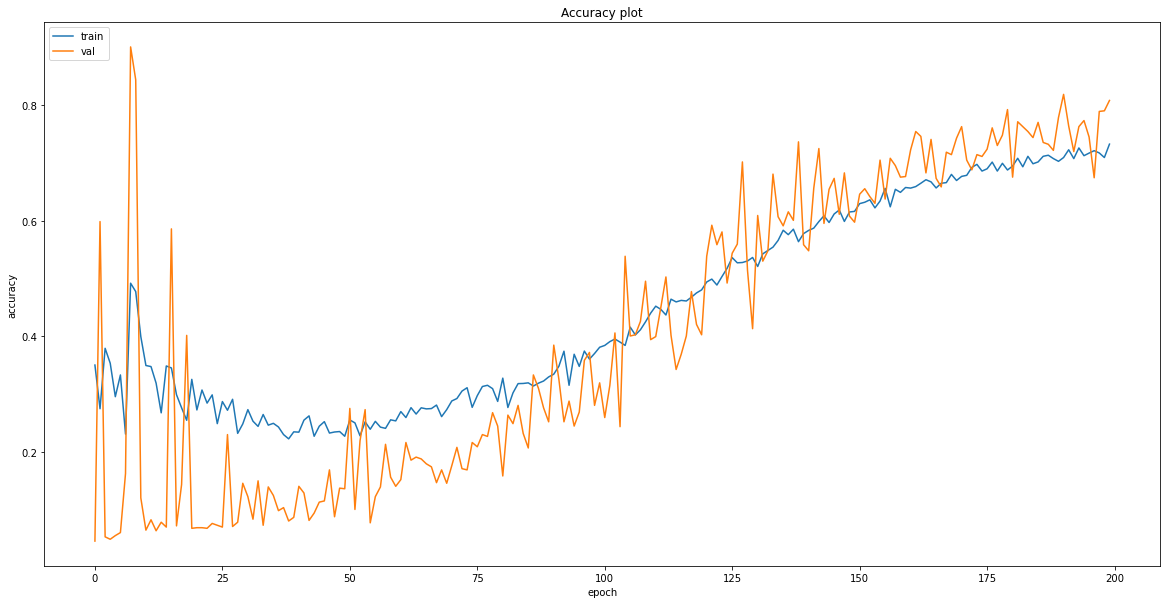

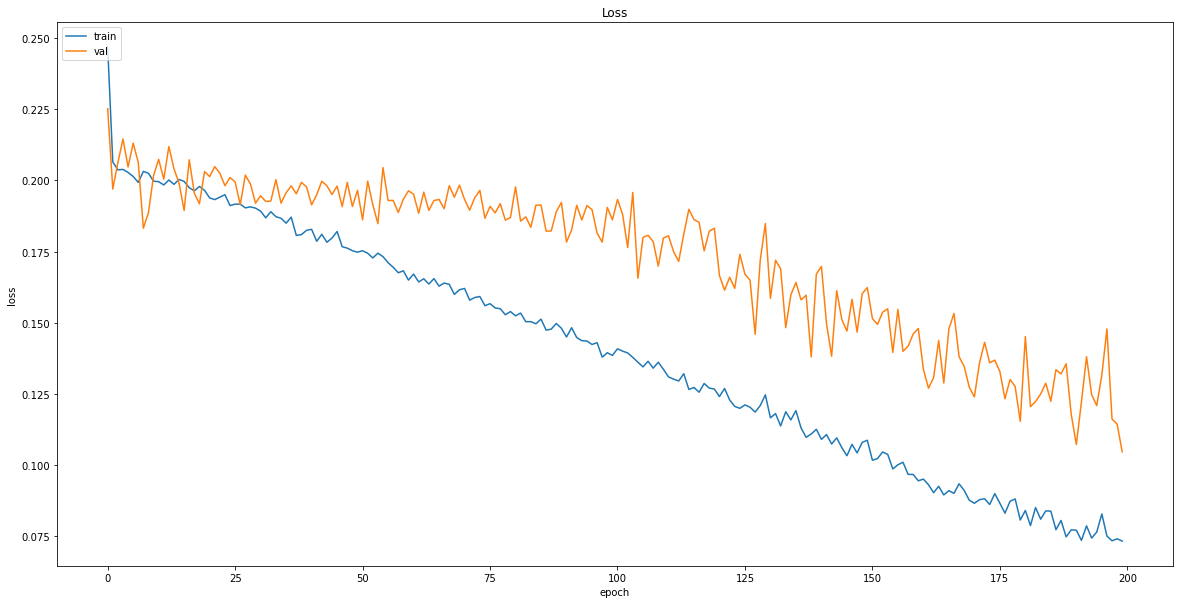

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('MFC_no_support_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/MFC_no_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,16.10,15.369379,-4.347841,12991200.0,2.0
2019-01-23,15.75,15.427936,-19.565241,11195700.0,2.0
2019-01-24,15.79,15.483638,-19.902947,12310800.0,2.0
2019-01-25,15.63,15.506155,-34.131754,10454700.0,2.0
2019-01-28,15.75,15.543670,-30.405447,11863600.0,2.0


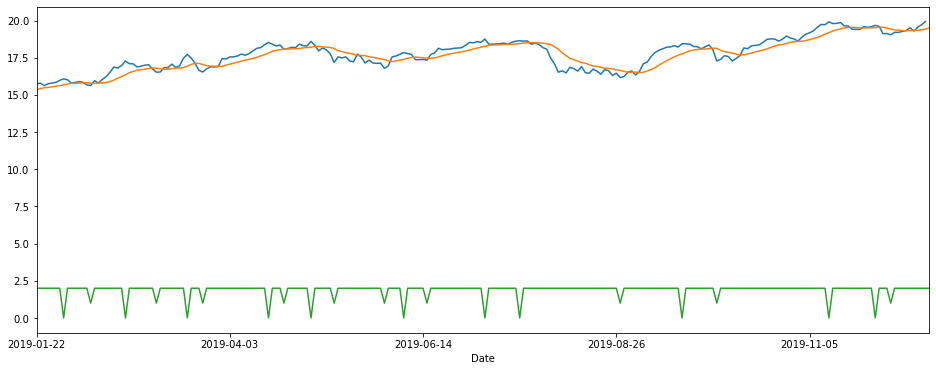

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/MFC_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 11ms/step - loss: 0.0995 - accuracy: 0.8486 - mean_squared_error: 2.0957 - weighted_accuracy: 0.8486 - weighted_mean_squared_error: 2.0957
Test loss: 0.09946618229150772
Test accuracy: 0.8486238718032837


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 201, 0: 7, 1: 10})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 10, 2: 198, 0: 10})

In [40]:
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,15.630000,15.794888,-75.000000,15118200.0,1.0,2,1
2019-02-12,15.960000,15.769520,-80.303008,13534100.0,2.0,2,2
2019-02-13,15.800000,15.798825,-30.303008,15499400.0,2.0,2,2
2019-02-14,16.040001,15.799006,-54.545415,12941900.0,2.0,2,2
2019-02-15,16.230000,15.836082,-41.935404,16615800.0,2.0,2,2


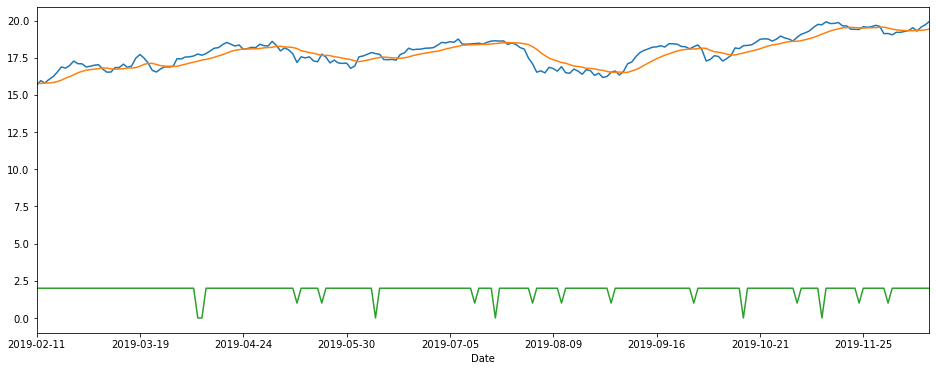

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

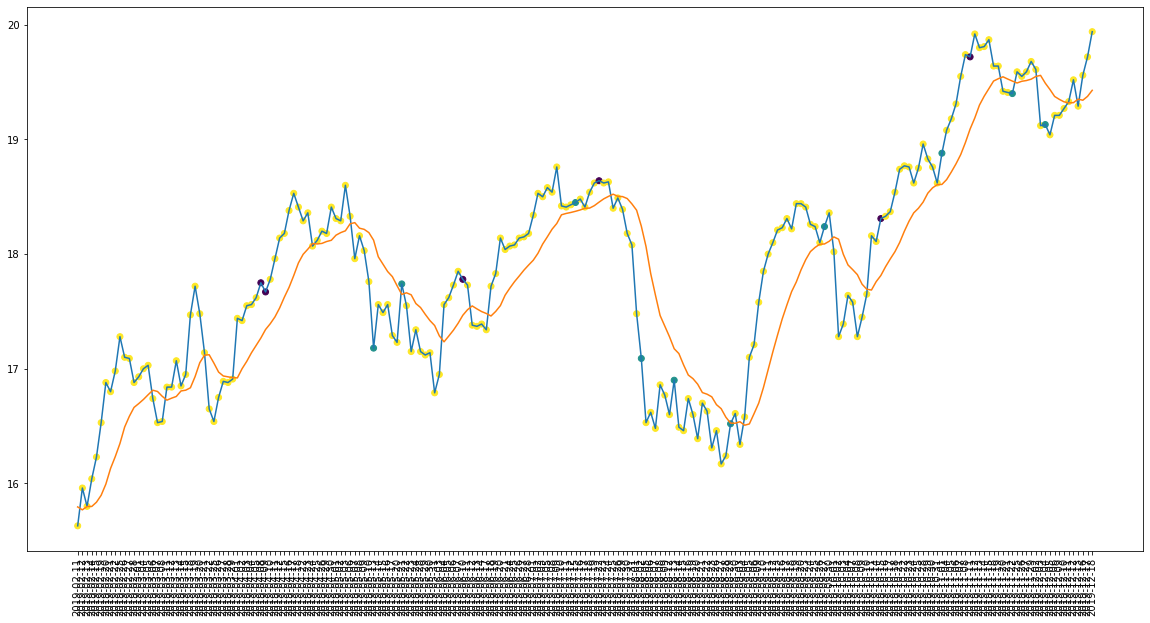

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

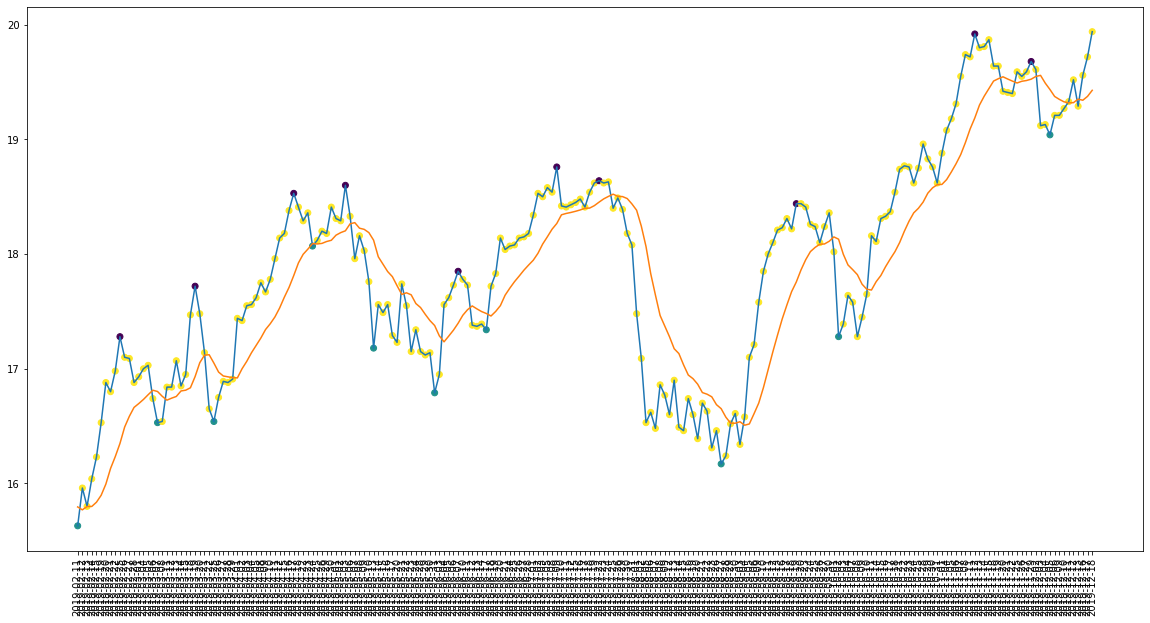

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 9
actual holds but predicted sell: 6
actual predicted holds: 183
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 92.42424242424242%
actual buys: 10
actual sells: 10
actual holds: 198


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[15.630000114440918, 15.800000190734865, 15.960000038146973, 16.040000915527347, 16.229999542236328, 16.530000686645508, 16.799999237060547, 16.879999160766598, 16.979999542236328]
[16.799999237060547, 16.879999160766598, 16.879999160766598, 16.930000305175778, 16.979999542236328, 17.0, 17.09000015258789, 17.100000381469727, 17.280000686645508]
Percentage buys correct: 40.0%
Percentage sells correct: 50.0%
Percentage holds correct: 85.07462686567165%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $17.180000305175778
Shares owned at the moment: 580
Cash capital at the moment: $8.19772251129325


Price increase from previously bought: 8.200696388413053%
Share price: $18.63999938964844
Shares owned at the moment: 0
Cash capital at the moment: $10789.6665694809


Share price: $17.09000015258789
Shares owned at the moment: 629
Cash capital at the moment: $10.49504573917693


Stop Loss Activated!

Share price: $16.530000686645508
Shares owned at the moment: 0
Cash capital at the moment: $10379.272708951476


Share price: $16.899999618530273
Shares owned at the moment: 612
Cash capital at the moment: $8.030243052960941


Stop Loss Activated!

Share price: $16.389999389648438
Shares owned at the moment: 0
Cash capital at the moment: $10011.125500545026


Share price: $16.520000457763672
Shares owned at the moment: 604
Cash capital at the moment: $5.60550329542275


Price increase from previously bought: 10.531383481011014%
Share price: $18.309999465942386
Shares owned at t

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12687.37270157766
profit gained: 26.873727015776605%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.848624,10.0%,10.0%,92.42424242424242%,40.0%,50.0%,85.07462686567165%,15.892216613554954%,26.873727015776605%


### Recession test data

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    20.620001  20.787224 -56.481365  5587900.0     2.0
2020-01-23    20.760000  20.783036 -48.453572  7034300.0     2.0
2020-01-24    20.799999  20.785645 -44.329960  8383300.0     2.0
2020-01-27    20.650000  20.764777 -59.793849  5159000.0     2.0
2020-01-28    20.030001  20.651734 -87.591226  2998800.0     2.0


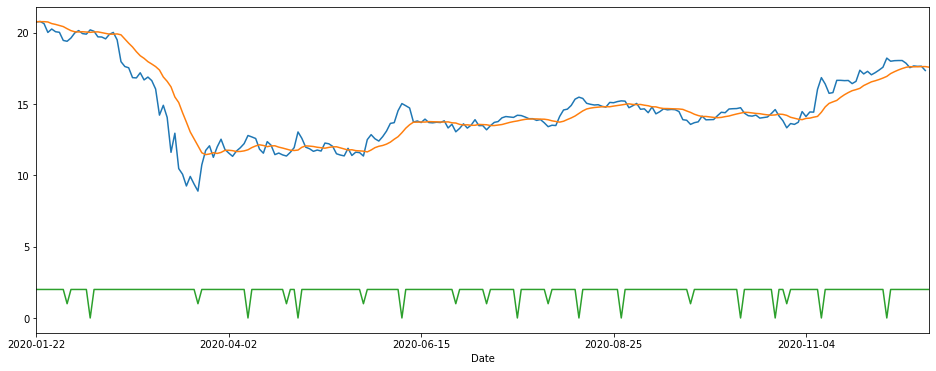

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [54]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/MFC_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1059 - accuracy: 0.7991 - mean_squared_error: 2.2888 - weighted_accuracy: 0.7991 - weighted_mean_squared_error: 2.2888
Test loss: 0.10586494207382202
Test accuracy: 0.7990867495536804


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 188, 1: 20, 0: 11})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,20.209999,20.036581,-63.157941,-1529300.0,0.0,2,0
2020-02-12,20.110001,20.063261,-43.421155,-126100.0,2.0,2,2
2020-02-13,19.719999,20.070452,-50.000000,-2453200.0,2.0,2,2
2020-02-14,19.709999,20.016536,-62.626362,-4848700.0,2.0,2,2
2020-02-18,19.580000,19.969377,-63.636486,-6866400.0,2.0,2,2


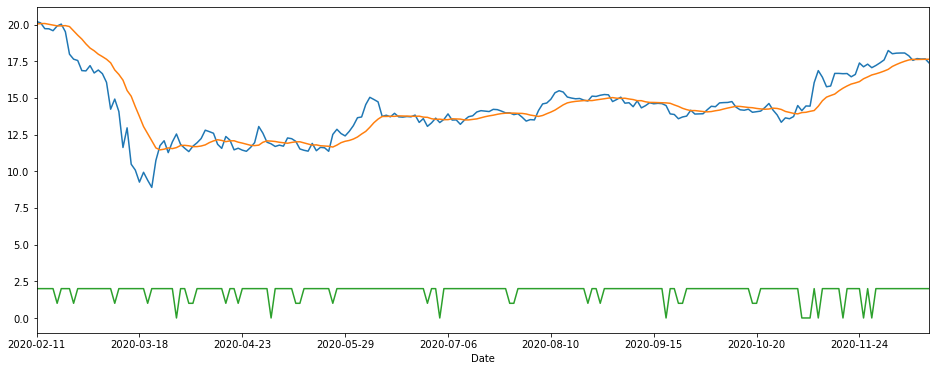

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

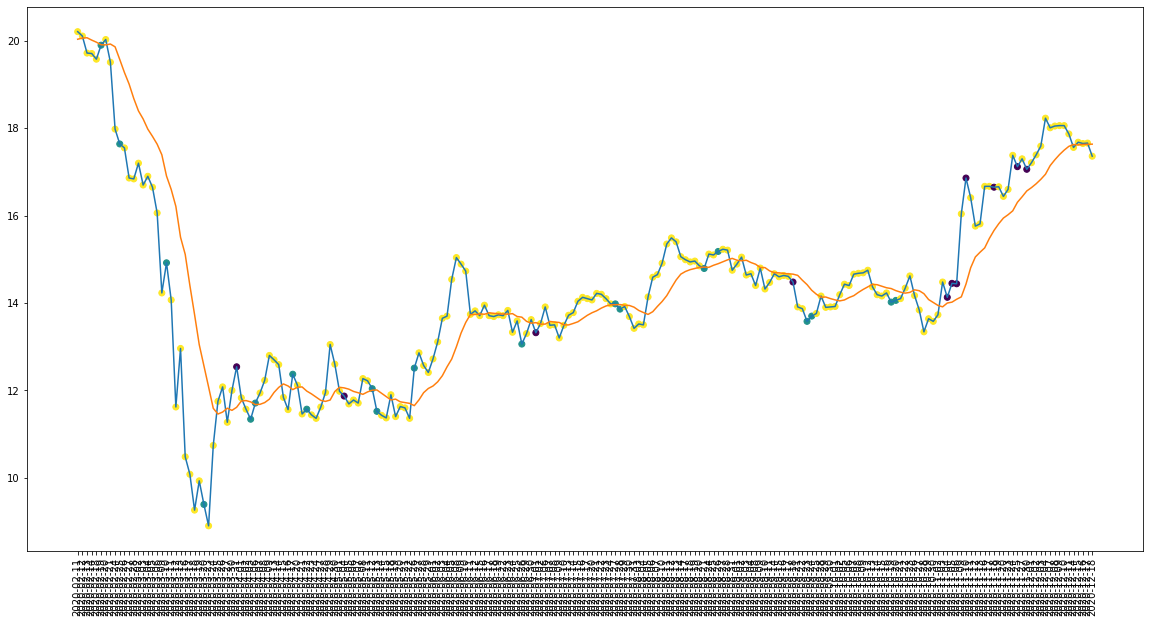

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

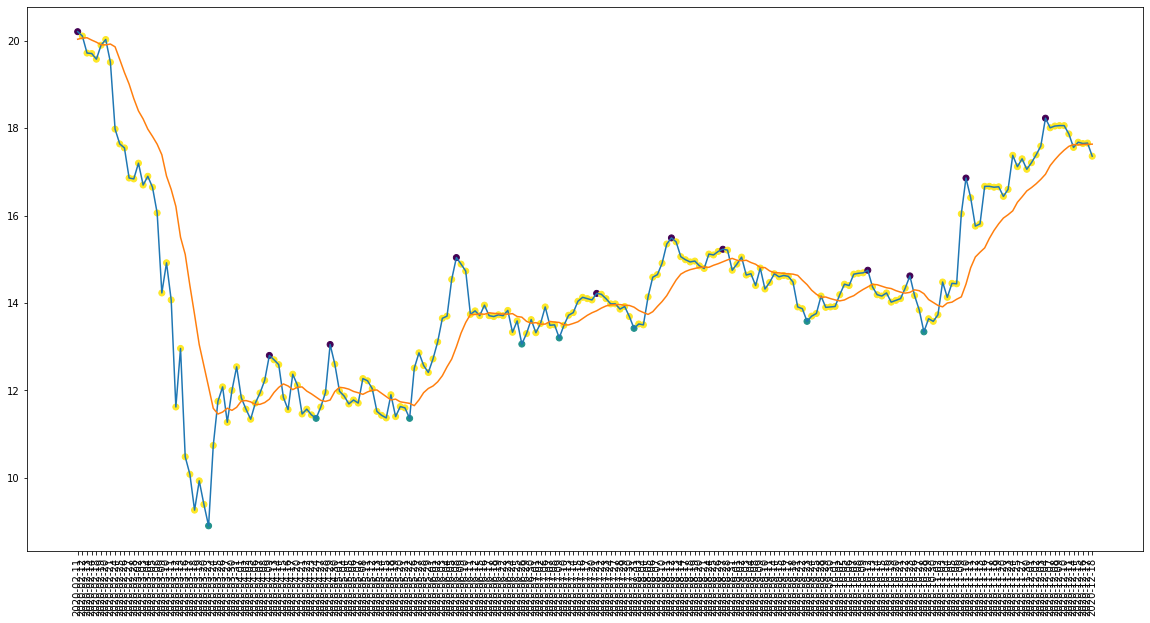

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 18
actual holds but predicted sell: 10
actual predicted holds: 172
Percentage buys correct: 25.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 86.0%
actual buys: 8
actual sells: 11
actual holds: 200


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[17.979999542236328, 19.51000022888184, 19.57999992370605, 19.709999084472656, 19.71999931335449, 19.899999618530273, 20.030000686645508, 20.11000061035156, 20.209999084472656]
[16.700000762939453, 16.84000015258789, 16.860000610351562, 17.200000762939453, 17.549999237060547, 17.639999389648438, 17.979999542236328, 19.51000022888184, 20.030000686645508]
Percentage buys correct: 55.0%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 85.02673796791444%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $19.899999618530273
Shares owned at the moment: 501
Cash capital at the moment: $2.6829666419034766


Stop Loss Activated!

Share price: $17.979999542236328
Shares owned at the moment: 0
Cash capital at the moment: $8985.890792932987


Share price: $17.639999389648438
Shares owned at the moment: 508
Cash capital at the moment: $0.12802384424139746


Stop Loss Activated!

Share price: $16.860000610351562
Shares owned at the moment: 0
Cash capital at the moment: $8541.454913050175


Share price: $14.920000076293945
Shares owned at the moment: 570
Cash capital at the moment: $13.667769443034558


Stop Loss Activated!

Share price: $14.06999969482422
Shares owned at the moment: 0
Cash capital at the moment: $8011.512870971203


Share price: $9.390000343322754
Shares owned at the moment: 850
Cash capital at the moment: $8.063453344344452


Stop Loss Activated!

Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $7552.259379986762


Share p

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8544.015225172043
profit gained: -14.559847748279573%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.848624,10.0%,10.0%,92.42424242424242%,40.0%,50.0%,85.07462686567165%,15.892216613554954%,26.873727015776605%
1,0.799087,25.0%,9.090909090909092%,86.0%,55.0%,18.181818181818183%,85.02673796791444%,-14.177789706330332%,-14.559847748279573%


### with JPM stock price

In [71]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.09375,6.133837,-56.250000,1982400.0,2.0
2000-01-24,6.06250,6.122862,-60.000000,1705200.0,2.0
2000-01-25,5.96875,6.099153,-80.000000,909600.0,2.0
2000-01-26,6.00000,6.083898,-73.333333,1179600.0,2.0
2000-01-27,5.96875,6.066183,-80.000000,783000.0,2.0


In [72]:
df2 = pd.read_csv("data/variation 6/initial_indicators/JPM_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [73]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2000-01-21,6.09375,6.133837,-56.250000,1982400.0,2.0,49.375000
2000-01-24,6.06250,6.122862,-60.000000,1705200.0,2.0,48.625000
2000-01-25,5.96875,6.099153,-80.000000,909600.0,2.0,48.666668
2000-01-26,6.00000,6.083898,-73.333333,1179600.0,2.0,49.750000
2000-01-27,5.96875,6.066183,-80.000000,783000.0,2.0,52.291668


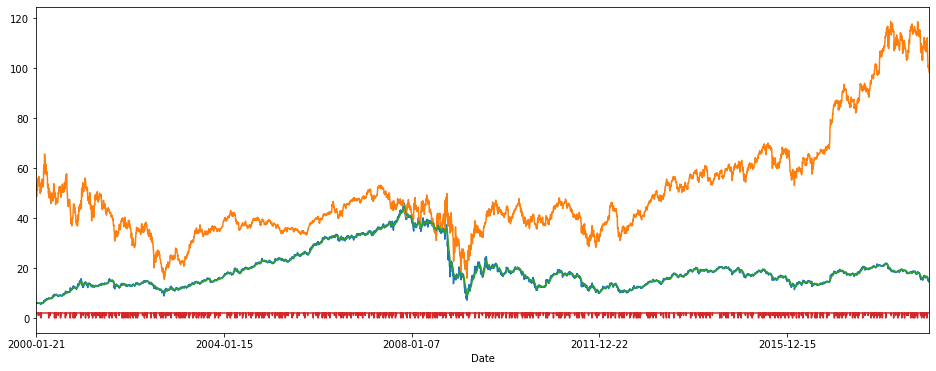

In [74]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [75]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [77]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

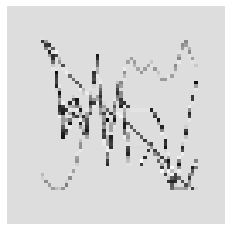

In [78]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [79]:
X = X/255

In [80]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [81]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [82]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [84]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 6.9523809523809526, 1: 7.3996101364522415, 2: 0.3675089553683803}
Epoch 1/200
30/30 [==============================] - 2s 83ms/step - loss: 0.2494 - accuracy: 0.3672 - mse: 1.6285 - weighted_accuracy: 0.2908 - weighted_mse: 1.7629 - val_loss: 0.2206 - val_accuracy: 0.0453 - val_mse: 0.8624 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.8624
Epoch 2/200
30/30 [==============================] - 0s 15ms/step - loss: 0.2061 - accuracy: 0.3243 - mse: 1.1550 - weighted_accuracy: 0.3426 - weighted_mse: 1.1793 - val_loss: 0.2125 - val_accuracy: 0.0485 - val_mse: 0.8873 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.8873
Epoch 3/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2046 - accuracy: 0.3654 - mse: 1.1631 - weighted_accuracy: 0.3521 - weighted_mse: 1.1787 - val_loss: 0.2009 - val_accuracy: 0.1602 - val_mse: 0.9062 - val_weighted_accuracy: 0.1602 - val_weighted_mse: 0.9062
Epoch 4/200
30/30 [==============================] - 0s 14ms/step - loss: 0.20

Epoch 57/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1740 - accuracy: 0.1507 - mse: 1.3082 - weighted_accuracy: 0.5406 - weighted_mse: 1.2346 - val_loss: 0.1945 - val_accuracy: 0.0896 - val_mse: 1.1869 - val_weighted_accuracy: 0.0896 - val_weighted_mse: 1.1869
Epoch 58/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1733 - accuracy: 0.1641 - mse: 1.3478 - weighted_accuracy: 0.5273 - weighted_mse: 1.2855 - val_loss: 0.2014 - val_accuracy: 0.0948 - val_mse: 1.0756 - val_weighted_accuracy: 0.0948 - val_weighted_mse: 1.0756
Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1722 - accuracy: 0.1636 - mse: 1.3216 - weighted_accuracy: 0.5323 - weighted_mse: 1.2825 - val_loss: 0.1968 - val_accuracy: 0.1222 - val_mse: 1.1781 - val_weighted_accuracy: 0.1222 - val_weighted_mse: 1.1781
Epoch 60/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1702 - accuracy: 0.1794 - mse: 1.3474 - weighted_accuracy: 0.5637 - 

Epoch 114/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1392 - accuracy: 0.2919 - mse: 1.6395 - weighted_accuracy: 0.6787 - weighted_mse: 1.7150 - val_loss: 0.1919 - val_accuracy: 0.2813 - val_mse: 1.5153 - val_weighted_accuracy: 0.2813 - val_weighted_mse: 1.5153
Epoch 115/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1371 - accuracy: 0.2985 - mse: 1.7121 - weighted_accuracy: 0.6766 - weighted_mse: 1.8390 - val_loss: 0.1910 - val_accuracy: 0.3024 - val_mse: 1.5637 - val_weighted_accuracy: 0.3024 - val_weighted_mse: 1.5637
Epoch 116/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1358 - accuracy: 0.2958 - mse: 1.7000 - weighted_accuracy: 0.6841 - weighted_mse: 1.8125 - val_loss: 0.1902 - val_accuracy: 0.3003 - val_mse: 1.5294 - val_weighted_accuracy: 0.3003 - val_weighted_mse: 1.5294
Epoch 117/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1370 - accuracy: 0.3016 - mse: 1.7160 - weighted_accuracy: 0.689

Epoch 171/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1064 - accuracy: 0.5801 - mse: 2.3566 - weighted_accuracy: 0.8031 - weighted_mse: 3.1772 - val_loss: 0.1569 - val_accuracy: 0.6270 - val_mse: 2.0434 - val_weighted_accuracy: 0.6270 - val_weighted_mse: 2.0434
Epoch 172/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1126 - accuracy: 0.5901 - mse: 2.3251 - weighted_accuracy: 0.7803 - weighted_mse: 3.1077 - val_loss: 0.1569 - val_accuracy: 0.6048 - val_mse: 2.0370 - val_weighted_accuracy: 0.6048 - val_weighted_mse: 2.0370
Epoch 173/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1116 - accuracy: 0.5917 - mse: 2.4007 - weighted_accuracy: 0.8023 - weighted_mse: 3.1356 - val_loss: 0.1578 - val_accuracy: 0.5869 - val_mse: 1.9890 - val_weighted_accuracy: 0.5869 - val_weighted_mse: 1.9890
Epoch 174/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1118 - accuracy: 0.6101 - mse: 2.3734 - weighted_accuracy: 0.797

Epoch 200/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1005 - accuracy: 0.6554 - mse: 2.9041 - weighted_accuracy: 0.8398 - weighted_mse: 4.1023 - val_loss: 0.1304 - val_accuracy: 0.7355 - val_mse: 2.3272 - val_weighted_accuracy: 0.7355 - val_weighted_mse: 2.3272


In [85]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13043057918548584
Test accuracy: 0.735511064529419


In [86]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.5592348  -2.0333884  -0.39339182]
 [-2.678255   -0.22682706 -0.5698436 ]
 [-1.330913   -1.1807383  -0.09590165]
 ...
 [-1.7733096  -1.302166   -0.05560493]
 [-1.0692393  -1.2257258  -0.19914237]
 [-0.73237836 -1.4384266  -0.35599083]]


Counter({2: 753, 1: 92, 0: 104})

In [87]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 46, 1: 43})

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 35
actual sells but predicted buy: 4
actual predicted sells: 8
actual sells but predicted hold: 34
actual holds but predicted buy: 82
actual holds but predicted sell: 94
actual predicted holds: 684
Percentage buys correct: 13.953488372093023%
Percentage sells correct: 17.391304347826086%
Percentage holds correct: 79.53488372093024%
actual buys: 43
actual sells: 46
actual holds: 860


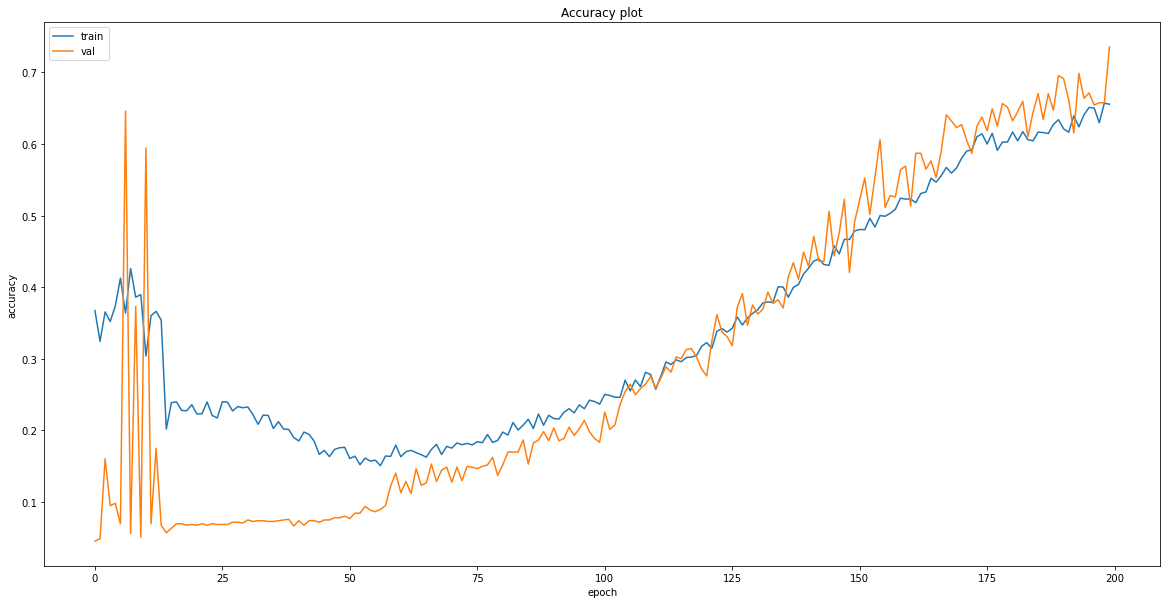

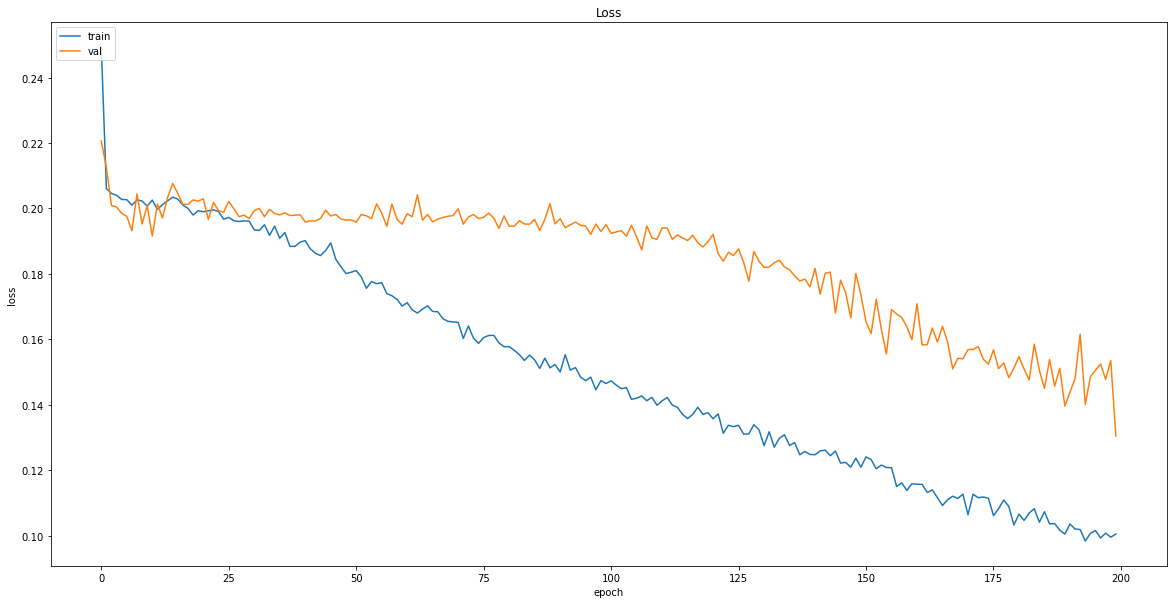

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
# Save model
model.save("models/{}".format('MFC_support_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/MFC_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [91]:
logger = []

In [92]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        16.10  15.369379  -4.347841  12991200.0     2.0
2019-01-23        15.75  15.427936 -19.565241  11195700.0     2.0
2019-01-24        15.79  15.483638 -19.902947  12310800.0     2.0
2019-01-25        15.63  15.506155 -34.131754  10454700.0     2.0
2019-01-28        15.75  15.543670 -30.405447  11863600.0     2.0


In [93]:
df2 = pd.read_csv("data/variation 6/initial_indicators/JPM_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,104.589996,101.198442,-3.459880,84335200.0,2.0
2019-01-23,102.940002,101.466374,-21.874992,67251500.0,2.0
2019-01-24,102.680000,101.653086,-27.040213,55104800.0,2.0
2019-01-25,102.739998,101.820303,-32.628441,66401600.0,2.0
2019-01-28,103.389999,102.061795,-23.968276,80771000.0,2.0


In [94]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2019-01-22,16.10,15.369379,-4.347841,12991200.0,2.0,104.589996
2019-01-23,15.75,15.427936,-19.565241,11195700.0,2.0,102.940002
2019-01-24,15.79,15.483638,-19.902947,12310800.0,2.0,102.680000
2019-01-25,15.63,15.506155,-34.131754,10454700.0,2.0,102.739998
2019-01-28,15.75,15.543670,-30.405447,11863600.0,2.0,103.389999


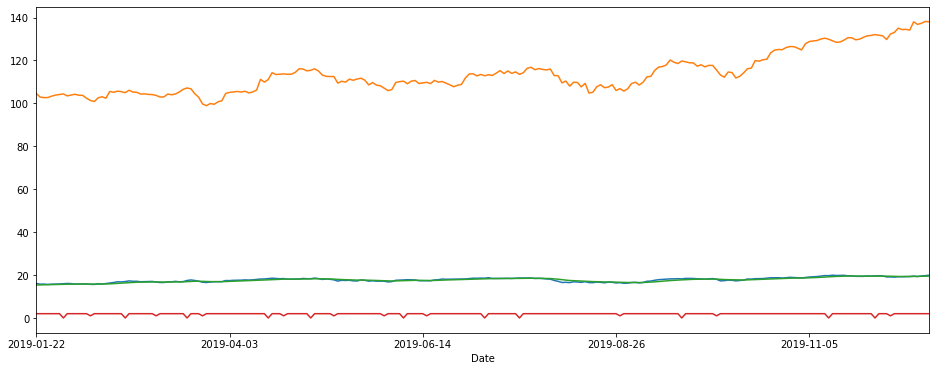

In [95]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [96]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [98]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [99]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [100]:
model = tf.keras.models.load_model("models/MFC_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 5ms/step - loss: 0.1296 - accuracy: 0.7523 - mean_squared_error: 2.3381 - weighted_accuracy: 0.7523 - weighted_mean_squared_error: 2.3381
Test loss: 0.12957729399204254
Test accuracy: 0.752293586730957


In [101]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 21, 2: 174, 0: 23})

In [102]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 10, 2: 198, 0: 10})

In [103]:
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test.csv")
df.set_index('Date', inplace=True)

In [104]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,15.630000,15.794888,-75.000000,15118200.0,1.0,1,1
2019-02-12,15.960000,15.769520,-80.303008,13534100.0,2.0,1,2
2019-02-13,15.800000,15.798825,-30.303008,15499400.0,2.0,2,2
2019-02-14,16.040001,15.799006,-54.545415,12941900.0,2.0,2,2
2019-02-15,16.230000,15.836082,-41.935404,16615800.0,2.0,2,2


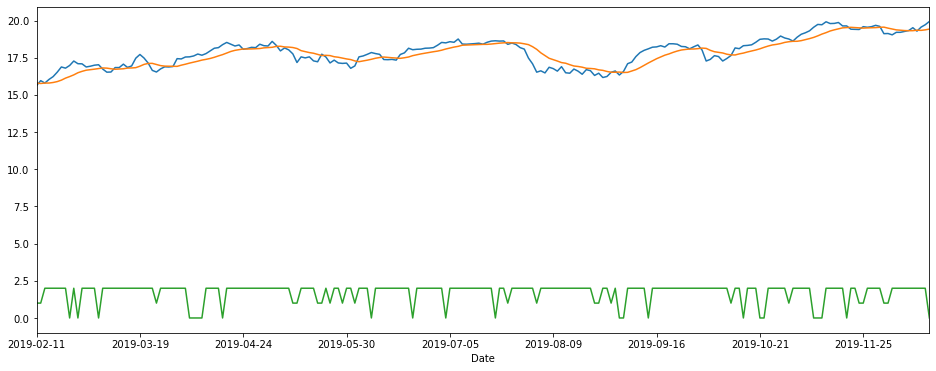

In [105]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

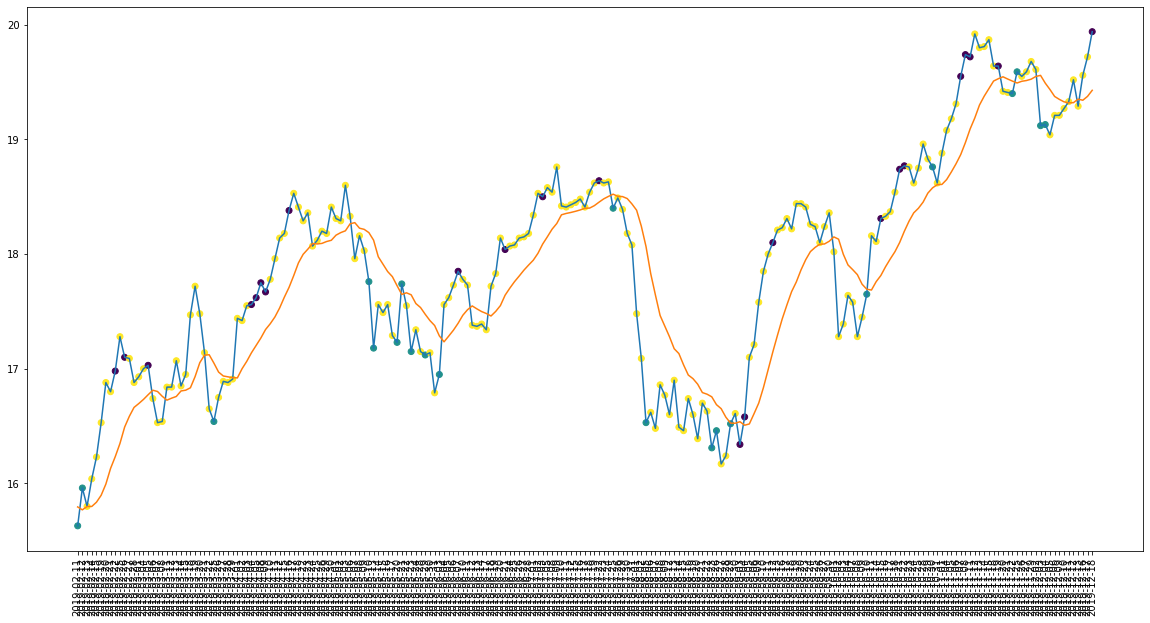

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

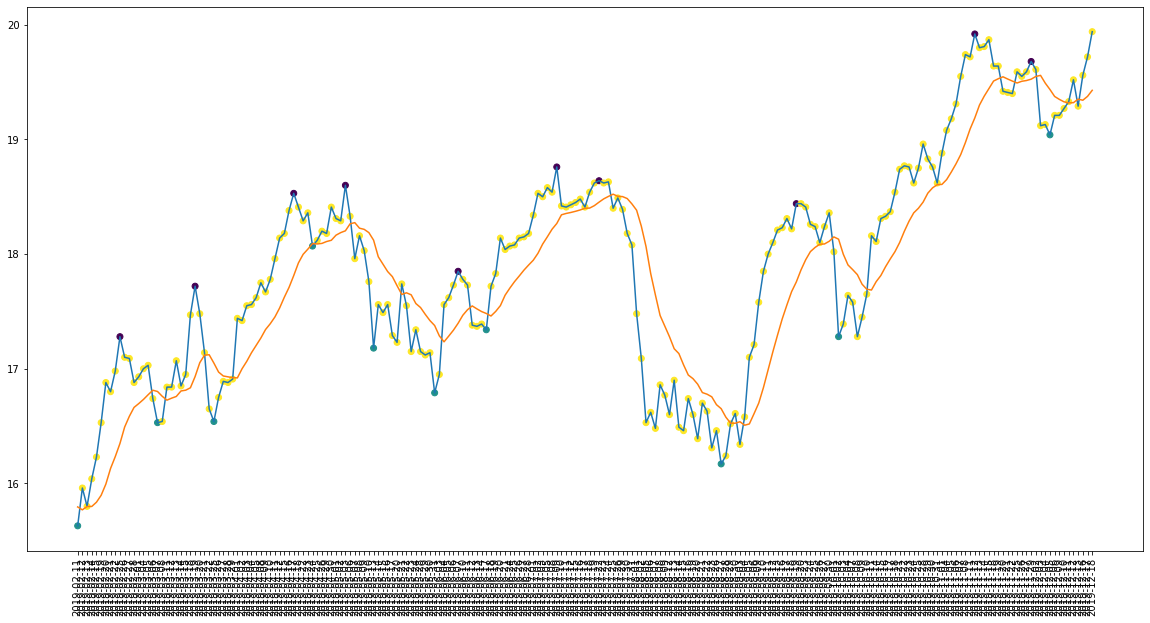

In [107]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [108]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 21
actual predicted holds: 159
Percentage buys correct: 30.0%
Percentage sells correct: 20.0%
Percentage holds correct: 80.3030303030303%
actual buys: 10
actual sells: 10
actual holds: 198
[15.630000114440918, 15.800000190734865, 15.960000038146973, 16.040000915527347, 16.229999542236328, 16.530000686645508, 16.799999237060547, 16.879999160766598, 16.979999542236328]
[16.799999237060547, 16.879999160766598, 16.879999160766598, 16.930000305175778, 16.979999542236328, 17.0, 17.09000015258789, 17.100000381469727, 17.280000686645508]
Percentage buys correct: 71.42857142857143%
Percentage sells correct: 52.17391304347826%
Percentage holds correct: 84.39306358381504%


In [109]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $15.630000114440918
Shares owned at the moment: 638
Cash capital at the moment: $0.6370917859076144


Price increase from previously bought: 8.33929928723447%
Share price: $16.979999542236328
Shares owned at the moment: 0
Cash capital at the moment: $10804.08539053583


Share price: $16.540000915527347
Shares owned at the moment: 651
Cash capital at the moment: $6.934057888505777


Price increase from previously bought: 5.87570091532299%
Share price: $17.559999465942386
Shares owned at the moment: 0
Cash capital at the moment: $11407.056921173094


Share price: $17.760000228881836
Shares owned at the moment: 640
Cash capital at the moment: $9.399174285887057


Stop Loss Activated!

Share price: $17.180000305175778
Shares owned at the moment: 0
Cash capital at the moment: $10974.362569061275


Share price: $17.180000305175778
Shares owned at the moment: 637
Cash capital at the moment: $0.6073091297130304


Price increase from previously bought: 7.38803373015533%
Share price

In [110]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12687.37270157766
profit gained: 26.873727015776605%


In [111]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.848624,10.0%,10.0%,92.42424242424242%,40.0%,50.0%,85.07462686567165%,15.892216613554954%,26.873727015776605%
1,0.799087,25.0%,9.090909090909092%,86.0%,55.0%,18.181818181818183%,85.02673796791444%,-14.177789706330332%,-14.559847748279573%
2,0.752294,30.0%,20.0%,80.3030303030303%,71.42857142857143%,52.17391304347826%,84.39306358381504%,34.954496617975146%,26.873727015776605%


### Recession

In [112]:
logger = []

In [113]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    20.620001  20.787224 -56.481365  5587900.0     2.0
2020-01-23    20.760000  20.783036 -48.453572  7034300.0     2.0
2020-01-24    20.799999  20.785645 -44.329960  8383300.0     2.0
2020-01-27    20.650000  20.764777 -59.793849  5159000.0     2.0
2020-01-28    20.030001  20.651734 -87.591226  2998800.0     2.0


In [114]:
df2 = pd.read_csv("data/variation 6/initial_indicators/JPM_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,136.839996,137.690058,-77.454723,33776700.0,2.0
2020-01-23,136.679993,137.534664,-80.363881,26227600.0,2.0
2020-01-24,136.539993,137.381637,-69.867648,16881900.0,2.0
2020-01-27,133.149994,136.730615,-90.166021,1715500.0,1.0
2020-01-28,132.029999,136.007444,-79.004573,-11145000.0,2.0


In [115]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2020-01-22,20.620001,20.787224,-56.481365,5587900.0,2.0,136.839996
2020-01-23,20.760000,20.783036,-48.453572,7034300.0,2.0,136.679993
2020-01-24,20.799999,20.785645,-44.329960,8383300.0,2.0,136.539993
2020-01-27,20.650000,20.764777,-59.793849,5159000.0,2.0,133.149994
2020-01-28,20.030001,20.651734,-87.591226,2998800.0,2.0,132.029999


In [116]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/MFC_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 4ms/step - loss: 0.1367 - accuracy: 0.6712 - mean_squared_error: 2.4701 - weighted_accuracy: 0.6712 - weighted_mean_squared_error: 2.4701
Test loss: 0.13674311339855194
Test accuracy: 0.6712328791618347


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 157, 1: 34, 0: 28})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({0: 11, 2: 200, 1: 8})

In [123]:
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test2.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,20.209999,20.036581,-63.157941,-1529300.0,0.0,2,0
2020-02-12,20.110001,20.063261,-43.421155,-126100.0,2.0,2,2
2020-02-13,19.719999,20.070452,-50.000000,-2453200.0,2.0,2,2
2020-02-14,19.709999,20.016536,-62.626362,-4848700.0,2.0,2,2
2020-02-18,19.580000,19.969377,-63.636486,-6866400.0,2.0,2,2


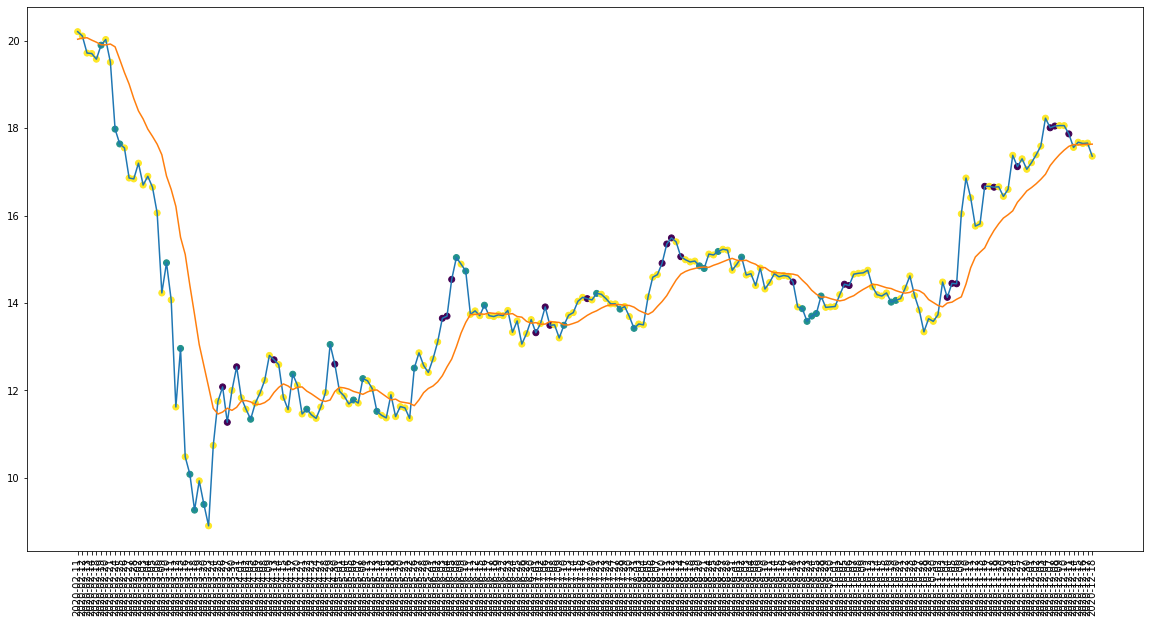

In [125]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

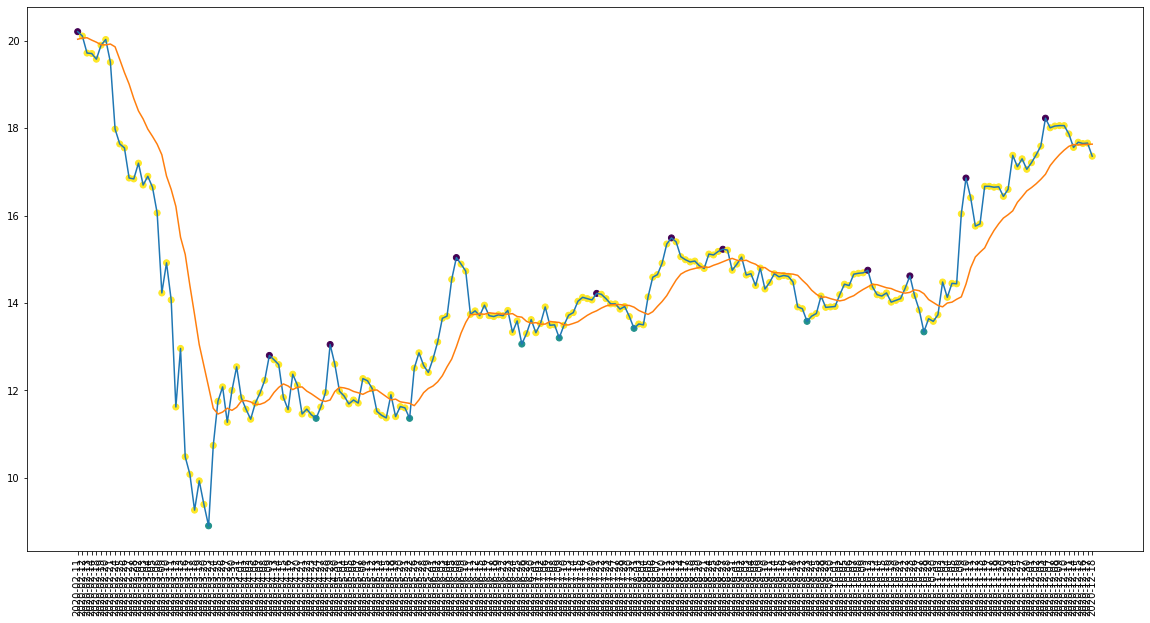

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [127]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 3
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 29
actual holds but predicted sell: 27
actual predicted holds: 144
Percentage buys correct: 25.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 72.0%
actual buys: 8
actual sells: 11
actual holds: 200
[17.979999542236328, 19.51000022888184, 19.57999992370605, 19.709999084472656, 19.71999931335449, 19.899999618530273, 20.030000686645508, 20.11000061035156, 20.209999084472656]
[16.700000762939453, 16.84000015258789, 16.860000610351562, 17.200000762939453, 17.549999237060547, 17.639999389648438, 17.979999542236328, 19.51000022888184, 20.030000686645508]
Percentage buys correct: 47.05882352941177%
Percentage sells correct: 46.42857142857143%
Percentage holds correct: 85.25641025641026%


In [128]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $19.899999618530273
Shares owned at the moment: 501
Cash capital at the moment: $2.6829666419034766


Stop Loss Activated!

Share price: $17.979999542236328
Shares owned at the moment: 0
Cash capital at the moment: $8985.890792932987


Share price: $17.979999542236328
Shares owned at the moment: 498
Cash capital at the moment: $7.227411526202559


Stop Loss Activated!

Share price: $16.860000610351562
Shares owned at the moment: 0
Cash capital at the moment: $8380.417944645404


Share price: $14.920000076293945
Shares owned at the moment: 560
Cash capital at the moment: $2.241101803301717


Stop Loss Activated!

Share price: $14.06999969482422
Shares owned at the moment: 0
Cash capital at the moment: $7859.773131374835


Share price: $12.960000038146973
Shares owned at the moment: 604
Cash capital at the moment: $10.406548270701933


Stop Loss Activated!

Share price: $10.479999542236328
Shares owned at the moment: 0
Cash capital at the moment: $6322.9189925417895


Share 

In [129]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8544.015225172043
profit gained: -14.559847748279573%


In [130]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.848624,10.0%,10.0%,92.42424242424242%,40.0%,50.0%,85.07462686567165%,15.892216613554954%,26.873727015776605%
1,0.799087,25.0%,9.090909090909092%,86.0%,55.0%,18.181818181818183%,85.02673796791444%,-14.177789706330332%,-14.559847748279573%
2,0.752294,30.0%,20.0%,80.3030303030303%,71.42857142857143%,52.17391304347826%,84.39306358381504%,34.954496617975146%,26.873727015776605%
3,0.671233,25.0%,9.090909090909092%,72.0%,47.05882352941177%,46.42857142857143%,85.25641025641026%,-43.72950931278476%,-14.559847748279573%


In [131]:
experiment

'MFC Variation 6 CNN Images Experiment'

In [132]:
log.to_csv('{}.csv'.format(experiment))